# Logistic Regression Model
----
All of the data from EDA is linear in nature. Other models can be viable but simple is almost always better as long as it performs well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

In [2]:
lol = pd.read_csv("./data/matches/processed_match_df.csv", compression="zip")

In [3]:
lol.head()

,match_id,game_duration,game_mode,game_type,game_version,t1p1_assists,t1p1_baronKills,t1p1_bountyLevel,t1p1_champExperience,t1p1_champLevel,...,t1-t2_total_totalDamageDealt_mod,t1-t2_total_totalDamageDealtToChampions_mod,t1-t2_total_totalDamageShieldedOnTeammates_mod,t1-t2_total_totalDamageTaken_mod,t1-t2_total_totalHeal_mod,t1-t2_total_totalHealsOnTeammates_mod,t1-t2_total_totalUnitsHealed_mod,t1-t2_total_trueDamageDealt_mod,t1-t2_total_trueDamageDealtToChampions_mod,t1-t2_total_trueDamageTaken_mod
0,NA1_4201994783,1470,CLASSIC,MATCHED_GAME,12.2.419.1399,7,0,0,8396,11,...,-199908.0,-21853.0,-13660.0,18183.0,-8029.0,-4127.0,-7.0,-173535.0,888.0,-885.0
1,NA1_4204324706,944,CLASSIC,MATCHED_GAME,12.3.421.3734,2,0,0,7015,10,...,-53092.0,-9822.0,902.0,6676.0,-1795.0,-903.0,5.0,-28335.0,-2402.0,2401.0
2,NA1_4215791943,1629,CLASSIC,MATCHED_GAME,12.3.421.5967,5,1,4,14510,15,...,106361.0,16296.0,6231.0,5908.0,5463.0,-2614.0,0.0,-1508.0,-2469.0,6241.0
3,NA1_4200912084,1329,CLASSIC,MATCHED_GAME,12.2.419.1399,4,0,0,10220,13,...,-205800.0,-29921.0,0.0,18210.0,-703.0,2634.0,6.0,-21802.0,-3337.0,3337.0
4,NA1_4218373259,1718,CLASSIC,MATCHED_GAME,12.3.421.5967,3,0,0,14922,16,...,-130649.0,-7203.0,-1049.0,3282.0,-18145.0,0.0,0.0,-27891.0,5414.0,-5433.0


In [4]:
lol.shape

(17493, 1351)

# Feature Selection
----
Logistic Regression is a linear model and thus Pearson Correlation (default `.corr()`) will function well with the model as long as the features are linear.

In [5]:
lol.corrwith(lol["t1_win"]).sort_values(ascending=False)[0:50]

t1_win                                         1.000000
t1-t2_total_goldEarned                         0.908458
t1-t2_total_champLevel                         0.900362
t1-t2_tower_kills                              0.875399
t1-t2_total_bountyLevel                        0.865795
t1-t2_total_kills                              0.854749
t1-t2_champion_kills                           0.854396
t1-t2_total_damageDealtToTurrets_mod           0.841732
t1-t2_total_damageDealtToTurrets               0.841543
t1-t2_total_damageDealtToObjectives_mod        0.823744
t1-t2_total_damageDealtToObjectives            0.823091
t1-t2_avgDominanceRatio                        0.812683
t1_total_bountyLevel                           0.802261
t1-t2_total_assists                            0.793132
t1_avgDominanceRatio                           0.773425
t1-t2_total_goldSpent                          0.763658
t2_turretsLost                                 0.762409
t1_tower_kills                                 0

Due to how EDA was done most of the values in the dataset are accounted for by the t1-t2 features.

The few standouts that are not in the `t1-t2` features are `t#_nexusLost` but that is a direct correlation as winning is determined by killing the Nexus this is a direct implication of the target.

The Match Features are not overly correlated to team victory so these can safely be left out. As such to start the `t1-t2` values as well as `t1_largerKillingSpree` is the best spot to start modelling.

In [6]:
features = [feature for feature in lol.corrwith(lol["t1_win"]).sort_values(ascending=False).index
            if feature.startswith("t1-t2")]

#append the only features from EDA that does not start with t1-t2
features.append("t1_largerkillingSpree")

# remove kills, deaths and assists. This is accounted for in dominance ratio
features = [feature for feature in features
            if feature not in ["t1-t2_total_kills", "t1-t2_total_deaths", "t1-t2_total_assists"]]

# has a NaN for correlation
features.remove("t1-t2_total_sightWardsBoughtInGame")

# Baseline
----

In [7]:
print(f"The baseline model is {lol['t1_win'].mean():.3%}")

The baseline model is 47.768%


# Modelling
----

## First Model - Basic
The first model is going to be a basic model and will not include much in the way of feature selection or the modified columns for games over 40 minutes. This will serve as a null hypothesis for future models to determine whether the modifications improve or hurt the model.

In [8]:
desired_features = [feature for feature in features if "mod" not in feature]

In [9]:
X = lol[desired_features]
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)
lol["preds"] = logreg.predict(X);

In [10]:
scores = cross_val_score(logreg, X, y, cv=10, scoring="r2", n_jobs=-1)

print(f"R2 Score: {scores.mean():.3%} ± {2 * scores.std():.3}")

R2 Score: 96.907% ± 0.0127


In [11]:
tn, fp, fn, tp = confusion_matrix(y, logreg.predict(X)).ravel()
print(f"The number of True Negatives is {tn}\n"
      f"The number of False Positives is {fp}\n"
      f"The number of False Negatives is {fn}\n"
      f"The number of True Positives is {tp}")

The number of True Negatives is 8590
The number of False Positives is 547
The number of False Negatives is 672
The number of True Positives is 7684


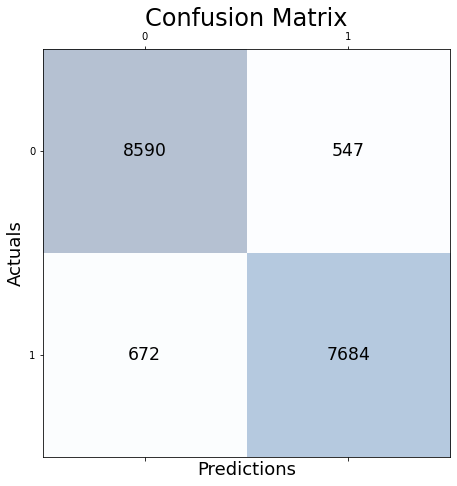

In [12]:
conf_matrix = confusion_matrix(y, logreg.predict(X))
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor="w")
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18);

In [13]:
accuracy = (tp + tn) / len(y)
precision = tp / (tp + fp)
sensitivity = tp / (fn + tp)
recall = tp / (tp + fn)

f1 = cross_val_score(logreg, X, y, cv=10, scoring="f1", n_jobs=-1)

print(f"F1 Score: {f1.mean():.3} ± {2 * f1.std():.3}\n"
      f"R2 Score: {scores.mean():.3} ± {2 * scores.std():.3}"
      "\n\n"
      f"Accuracy: {accuracy:.3%}\n"
      f"Precision: {precision:.3%}\n"
      f"Sensitivity {sensitivity:.3%}\n"
      f"Recall: {recall:.3%}")

F1 Score: 0.992 ± 0.00332
R2 Score: 0.969 ± 0.0127

Accuracy: 93.031%
Precision: 93.354%
Sensitivity 91.958%
Recall: 91.958%


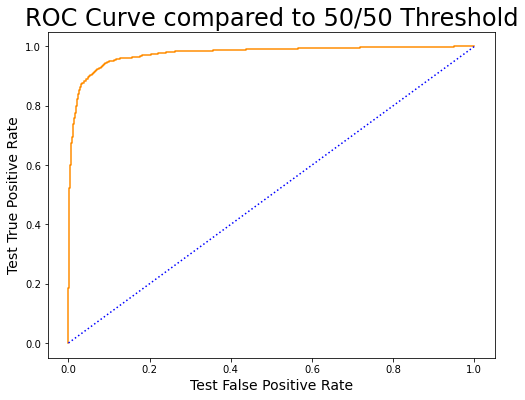

In [14]:
#calculate y_train fpr, tpr and thresholds
y_train_score = logreg.decision_function(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

#calculate y_test fpr, tpr and thresholds
y_test_score = logreg.decision_function(X_test)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

#plot
plt.figure(figsize=(8,6), facecolor="w")
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve')
plt.plot(np.linspace(0,1), np.linspace(0,1), color="b", linestyle='dotted')

plt.title("ROC Curve compared to 50/50 Threshold", size=24)
plt.xlabel("Test False Positive Rate", size=14)
plt.ylabel("Test True Positive Rate", size=14);

## Interpretation
----
These results are quite good and indicative of the work that went into the EDA and cleaning process.

As the baseline is 47.7% this model can be accepted as superior to the baseline model.

There are still a decent amount of False Positives and False Negatives which will likely be able to be reduced with additional feature selection. The model is almost assuredly overfit right now despite the fairly high R2 CV Score.

The ROC curve is fairly right angled which is great for a preliminary pass but it visually confirms there are flaws in the model which can hopefully be resolved.


## Second Model - Reduce Complexity
----
A few improvements can be made to the second model by reducing complexity.
 - `t1-t2_turretsLost` needs to be removed as it is directly correlated to `t1-t2_tower_kills`
 - `t1-t2_inhibitorsLost` needs to be removed as it is directly correlated to `t1-t2_inhibitor_kills`
 - Remove all features which do not have at least a correlation coefficient of absolute value 0.5 or greater
 
This step reduces the complexity of the dataset from 55 features to 22 features.

In [15]:
desired_features = [feature for feature in features if "mod" not in feature]

In [16]:
desired_features = [feature for feature, val
                    in lol[desired_features].corrwith(lol["t1_win"]).sort_values(ascending=False).items()
                    if abs(val) > .5]

In [17]:
desired_features.remove("t1-t2_turretsLost")
desired_features.remove("t1-t2_inhibitorsLost")

In [18]:
X = lol[desired_features]
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)
lol["preds"] = logreg.predict(X);

In [19]:
scores = cross_val_score(logreg, X, y, cv=10, scoring="r2", n_jobs=-1)

print(f"R2 Score: {scores.mean():.3%} ± {2 * scores.std():.3}")

R2 Score: 96.701% ± 0.0172


In [20]:
tn, fp, fn, tp = confusion_matrix(y, logreg.predict(X)).ravel()
print(f"The number of True Negatives is {tn}\n"
      f"The number of False Positives is {fp}\n"
      f"The number of False Negatives is {fn}\n"
      f"The number of True Positives is {tp}")

The number of True Negatives is 8545
The number of False Positives is 592
The number of False Negatives is 728
The number of True Positives is 7628


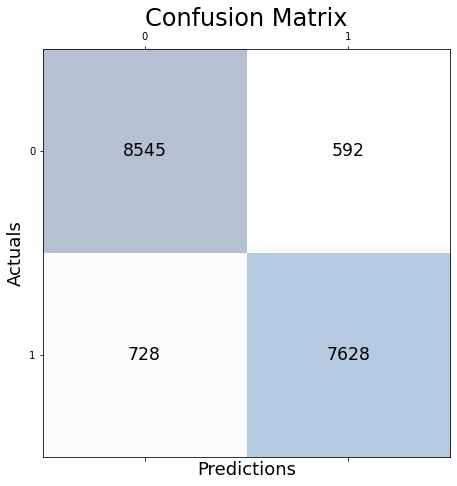

In [21]:
conf_matrix = confusion_matrix(y, logreg.predict(X))
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor="w")
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18);

In [22]:
accuracy = (tp + tn) / len(y)
precision = tp / (tp + fp)
sensitivity = tp / (fn + tp)
recall = tp / (tp + fn)

f1 = cross_val_score(logreg, X, y, cv=10, scoring="f1", n_jobs=-1)

print(f"F1 Score: {f1.mean():.3} ± {2 * f1.std():.3}\n"
      f"R2 Score: {scores.mean():.3} ± {2 * scores.std():.3}"
      "\n\n"
      f"Accuracy: {accuracy:.3%}\n"
      f"Precision: {precision:.3%}\n"
      f"Sensitivity {sensitivity:.3%}\n"
      f"Recall: {recall:.3%}")

F1 Score: 0.991 ± 0.00449
R2 Score: 0.967 ± 0.0172

Accuracy: 92.454%
Precision: 92.798%
Sensitivity 91.288%
Recall: 91.288%


## Interpretation
----
The second model actually performed worse than the first model despite having a higher R2 score.

The False Positives and False Negatives actually rose signifigantly in the second model as the reduced complexity and bias in the dataset caused the noise in the data to have a larger effect in the modelling process.

## Third Model - Reduce Noise
----
The only alteration in the third model will be to switch the standard columns for the modified columns which will prove that the modifications to the longer matches did in fact reduce the noise in the dataset.

However, due to `t1-t2_total_physicalDamageDealtToChampions_mod` being over 0.5 correlation coefficient it will need to be dropped from the final feature selection as the data it represents is covered in total damage.

In [23]:
filter_features = [feature[:-4] for feature in features if "mod" in feature]

In [24]:
desired_features = [feature for feature in features if feature not in filter_features]

In [25]:
desired_features = [feature for feature, val
                    in lol[desired_features].corrwith(lol["t1_win"]).sort_values(ascending=False).items()
                    if abs(val) > .5]

In [26]:
desired_features.remove("t1-t2_turretsLost")
desired_features.remove("t1-t2_inhibitorsLost")
desired_features.remove("t1-t2_total_physicalDamageDealtToChampions_mod")

In [27]:
X = lol[desired_features]
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)
lol["preds"] = logreg.predict(X);

In [28]:
scores = cross_val_score(logreg, X, y, cv=10, scoring="r2", n_jobs=-1)

print(f"R2 Score: {scores.mean():.3%} ± {2 * scores.std():.3}")

R2 Score: 96.655% ± 0.0185


In [29]:
tn, fp, fn, tp = confusion_matrix(y, logreg.predict(X)).ravel()
print(f"The number of True Negatives is {tn}\n"
      f"The number of False Positives is {fp}\n"
      f"The number of False Negatives is {fn}\n"
      f"The number of True Positives is {tp}")

The number of True Negatives is 8658
The number of False Positives is 479
The number of False Negatives is 608
The number of True Positives is 7748


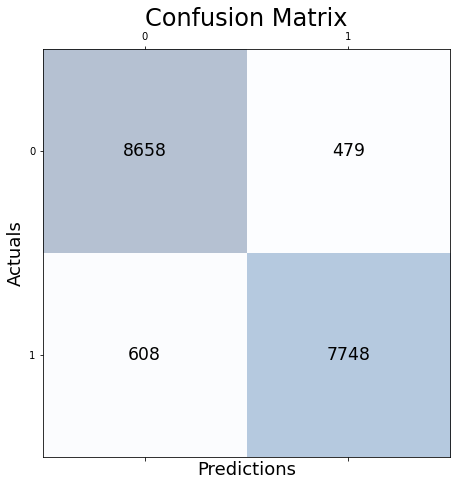

In [30]:
conf_matrix = confusion_matrix(y, logreg.predict(X))
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor="w")
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18);

In [31]:
accuracy = (tp + tn) / len(y)
precision = tp / (tp + fp)
sensitivity = tp / (fn + tp)
recall = tp / (tp + fn)

f1 = cross_val_score(logreg, X, y, cv=10, scoring="f1", n_jobs=-1)

print(f"F1 Score: {f1.mean():.3} ± {2 * f1.std():.3}\n"
      f"R2 Score: {scores.mean():.3} ± {2 * scores.std():.3}"
      "\n\n"
      f"Accuracy: {accuracy:.3%}\n"
      f"Precision: {precision:.3%}\n"
      f"Sensitivity {sensitivity:.3%}\n"
      f"Recall: {recall:.3%}")

F1 Score: 0.991 ± 0.00483
R2 Score: 0.967 ± 0.0185

Accuracy: 93.786%
Precision: 94.178%
Sensitivity 92.724%
Recall: 92.724%


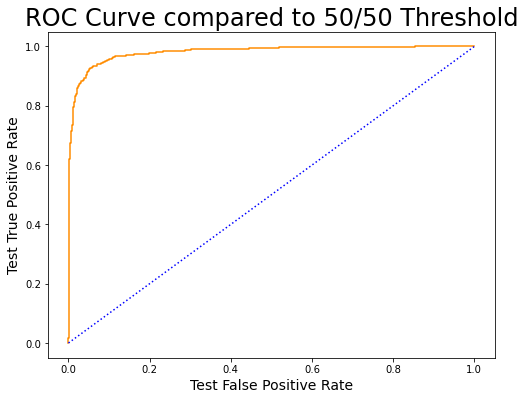

In [32]:
#calculate y_train fpr, tpr and thresholds
y_train_score = logreg.decision_function(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

#calculate y_test fpr, tpr and thresholds
y_test_score = logreg.decision_function(X_test)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

#plot
plt.figure(figsize=(8,6), facecolor="w")
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve')
plt.plot(np.linspace(0,1), np.linspace(0,1), color="b", linestyle='dotted')

plt.title("ROC Curve compared to 50/50 Threshold", size=24)
plt.xlabel("Test False Positive Rate", size=14)
plt.ylabel("Test True Positive Rate", size=14);

## Interpretation
----
By reducing complexity (Model 2) and noise (Model 3) the third model is outperforming both preliminary models.

All metrics show a very strong model which can accurately predict if a team won or lost a match based on the stats within the game. Maintaining over 90% scores in R2 and F1 support the conclusion that the model is not overfit and will function extremely well on future data.

Sadly, despite the improvements to the model the ROC curve still looks basically the same as it did at the onset.

In [33]:
X = lol[desired_features]
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)
lol["preds"] = logreg.predict(X);

## PCA
----
These values are all highly correlated to each other and one of the most useful techniques in Data Science for simplifying features is called PCA. PCA is a linear dimensionality reduction technique that transforms a set of correlated variables into a smaller k number of uncorrelated variables called principal components. The principal components retain as much of the original variation as possile while removing some of the noise from the dataset.

The most important step in using PCA is to examine how many principal components should be used in the final set. A simple way to do this is to plot the explained variance to the number of prinicpal components.

Eigenvalues:
['1: 1.5e+01', '2: 1.1', '3: 0.75', '4: 0.68', '5: 0.65', '6: 0.56', '7: 0.49', '8: 0.45', '9: 0.41', '10: 0.38', '11: 0.34', '12: 0.29', '13: 0.22', '14: 0.17', '15: 0.13', '16: 0.11', '17: 0.098', '18: 0.084', '19: 0.052', '20: 0.036', '21: 0.024', '22: 0.016'] 

Variances (Percentage):
['1: 67.89%', '2: 5.04%', '3: 3.41%', '4: 3.07%', '5: 2.96%', '6: 2.56%', '7: 2.22%', '8: 2.05%', '9: 1.85%', '10: 1.75%', '11: 1.56%', '12: 1.34%', '13: 1.00%', '14: 0.78%', '15: 0.59%', '16: 0.52%', '17: 0.45%', '18: 0.38%', '19: 0.23%', '20: 0.16%', '21: 0.11%', '22: 0.07%']


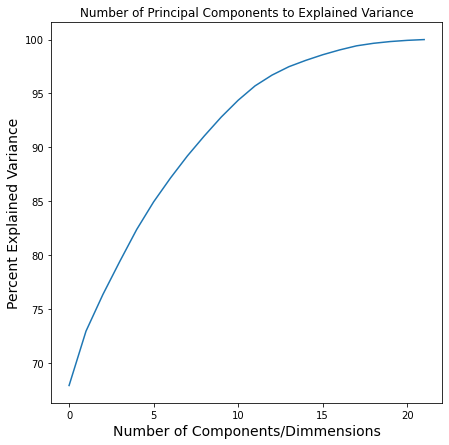

In [34]:
X = lol[desired_features]

ss = StandardScaler()
Xs = ss.fit_transform(X)

pca = PCA()
pca.fit(Xs)

# print the eigenvalues
print("Eigenvalues:")
print([f"{i+1}: {val:.2}" for i, val in enumerate(pca.explained_variance_)],"\n")

# print explained variance
print("Variances (Percentage):")
print([f"{i+1}: {val:.2%}" for i, val in enumerate(pca.explained_variance_ratio_)])

plt.figure(figsize=(7,7), facecolor="w")

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))

plt.title("Number of Principal Components to Explained Variance")
plt.xlabel("Number of Components/Dimmensions", size=14)
plt.ylabel("Percent Explained Variance", size=14);

In [35]:
data = [f"{val:.2%}" for i, val in enumerate(np.cumsum(pca.explained_variance_ratio_))]
pd.DataFrame(data, columns=["percent explained"], index=range(1, len(data) + 1))

,percent explained
1,67.89%
2,72.93%
3,76.33%
4,79.41%
5,82.37%
6,84.93%
7,87.16%
8,89.20%
9,91.06%
10,92.81%


## Interpretation
----
Based on the above information the vast majority of the data can be explained by less than half of the feature set. The question becomes were to draw the line?

Is keeping the simplicity of 8 Principal Components with reduced noise explaining 89.2% of the data the best option or is 11 Princpipal Components explaining 94.37% of the data the better option?

I am inclined to feel that adding 3 principal components to gain 6% explainatory value to reach 94% of total of 94% of the data explained is the best option but let's test this feeling.

## 8 Principal Compentents
----

In [36]:
X = lol[desired_features]

ss = StandardScaler()
Xs = ss.fit_transform(X)

#limit to the first 8 principal components
pca = PCA(n_components=8)
X_pca = pca.fit_transform(Xs)

# Transformed X dataset
X_pca = pd.DataFrame(X_pca)

In [37]:
X_pca.head()

,0,1,2,3,4,5,6,7
0,4.869729,0.227177,0.690883,-0.571447,0.359240,-0.488912,-0.671657,0.347594
1,2.541356,1.153108,-0.801533,-0.663847,1.169507,-0.163902,0.035260,0.027966
2,-4.230105,-0.494090,-1.047297,1.671581,-0.357408,0.740201,-0.332312,1.356922
3,5.311851,0.180369,0.259644,-0.234461,-0.675922,0.152316,0.416799,0.832220
4,4.343572,-0.963517,-0.302443,1.161295,-0.059593,-0.729214,-0.379986,-0.128979


#### PCA Logistic Regression, 8 PC's

In [38]:
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [39]:
scores = cross_val_score(logreg, X_pca, y, cv=10, scoring="r2", n_jobs=-1)

print(f"R2 Score: {scores.mean():.3%} ± {2 * scores.std():.3}")

R2 Score: 94.570% ± 0.0202


In [40]:
tn, fp, fn, tp = confusion_matrix(y, logreg.predict(X_pca)).ravel()
print(f"The number of True Negatives is {tn}\n"
      f"The number of False Positives is {fp}\n"
      f"The number of False Negatives is {fn}\n"
      f"The number of True Positives is {tp}")

The number of True Negatives is 8929
The number of False Positives is 208
The number of False Negatives is 160
The number of True Positives is 8196


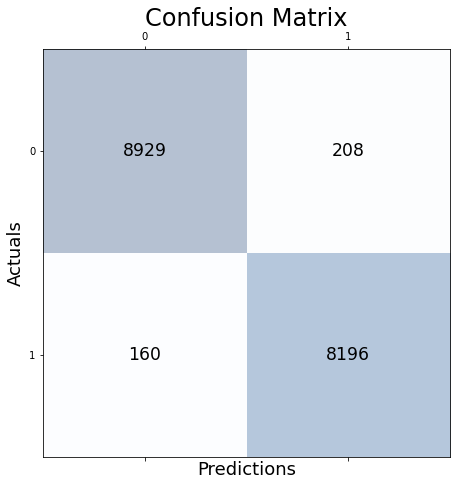

In [41]:
conf_matrix = confusion_matrix(y, logreg.predict(X_pca))
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor="w")
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18);

In [42]:
accuracy = (tp + tn) / len(y)
precision = tp / (tp + fp)
sensitivity = tp / (fn + tp)
recall = tp / (tp + fn)

f1 = cross_val_score(logreg, X_pca, y, cv=10, scoring="f1", n_jobs=-1)

print(f"F1 Score: {f1.mean():.3} ± {2 * f1.std():.3}\n"
      f"R2 Score: {scores.mean():.3} ± {2 * scores.std():.3}"
      "\n\n"
      f"Accuracy: {accuracy:.3%}\n"
      f"Precision: {precision:.3%}\n"
      f"Sensitivity {sensitivity:.3%}\n"
      f"Recall: {recall:.3%}")

F1 Score: 0.986 ± 0.00527
R2 Score: 0.946 ± 0.0202

Accuracy: 97.896%
Precision: 97.525%
Sensitivity 98.085%
Recall: 98.085%


## Interpretation
----
While the R2 Score actually decreased the remaining scores actually increased drastically around the board. The amount of False Positives and False Negatives dropped over 50% making a far superior model.

## 11 Principal Compentents
----

In [43]:
X = lol[desired_features]

ss = StandardScaler()
Xs = ss.fit_transform(X)

#limit to the first 8 principal components
pca = PCA(n_components=11)
X_pca = pca.fit_transform(Xs)

# Transformed X dataset
X_pca = pd.DataFrame(X_pca)

In [44]:
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,4.869729,0.227178,0.690883,-0.571445,0.359243,-0.488919,-0.671672,0.347593,-0.441342,-0.243447,-0.828552
1,2.541356,1.153108,-0.801532,-0.663846,1.169509,-0.163907,0.035251,0.027961,0.047310,0.444389,0.074306
2,-4.230105,-0.494090,-1.047296,1.671580,-0.357409,0.740204,-0.332306,1.356919,1.078845,0.017467,0.691810
3,5.311851,0.180370,0.259644,-0.234460,-0.675921,0.152313,0.416793,0.832222,0.174131,-0.413841,-0.175888
4,4.343572,-0.963513,-0.302442,1.161301,-0.059580,-0.729254,-0.380062,-0.128996,-0.070041,0.915508,1.062145


#### PCA Logistic Regression, 8 PC's

In [45]:
y = lol["t1_win"]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

logreg = LogisticRegression(solver = "liblinear", random_state=42)
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

logreg.fit(Xs_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [46]:
scores = cross_val_score(logreg, X_pca, y, cv=10, scoring="r2", n_jobs=-1)

print(f"R2 Score: {scores.mean():.3%} ± {2 * scores.std():.3}")

R2 Score: 96.403% ± 0.0165


In [47]:
tn, fp, fn, tp = confusion_matrix(y, logreg.predict(X_pca)).ravel()
print(f"The number of True Negatives is {tn}\n"
      f"The number of False Positives is {fp}\n"
      f"The number of False Negatives is {fn}\n"
      f"The number of True Positives is {tp}")

The number of True Negatives is 8946
The number of False Positives is 191
The number of False Negatives is 145
The number of True Positives is 8211


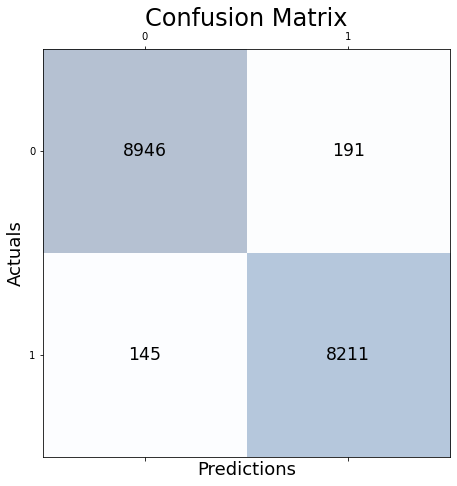

In [48]:
conf_matrix = confusion_matrix(y, logreg.predict(X_pca))
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor="w")
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18);

In [49]:
accuracy = (tp + tn) / len(y)
precision = tp / (tp + fp)
sensitivity = tp / (fn + tp)
recall = tp / (tp + fn)

f1 = cross_val_score(logreg, X_pca, y, cv=10, scoring="f1", n_jobs=-1)

print(f"F1 Score: {f1.mean():.3} ± {2 * f1.std():.3}\n"
      f"R2 Score: {scores.mean():.3} ± {2 * scores.std():.3}"
      "\n\n"
      f"Accuracy: {accuracy:.3%}\n"
      f"Precision: {precision:.3%}\n"
      f"Sensitivity {sensitivity:.3%}\n"
      f"Recall: {recall:.3%}")

F1 Score: 0.991 ± 0.00431
R2 Score: 0.964 ± 0.0165

Accuracy: 98.079%
Precision: 97.727%
Sensitivity 98.265%
Recall: 98.265%


### Interpretation
----
These high scores are generally red flags for an overfit model. However with a 10 folds in an 80:20 split if the model was overfit the 95% Confidence Interval wouldn't be within 1-2%.

I went into this project trying to ensure that I pushed EDA, Feature Engineering and Feature Selection to the max and these scores imply that I was successful.

The best way to test this would be to grab all new data and see what happens but that will be a project for another time.

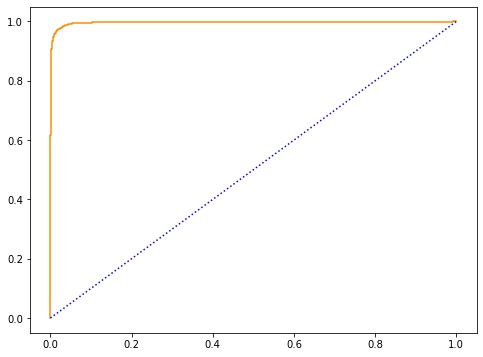

In [50]:
#calculate y_train fpr, tpr and thresholds
y_train_score = logreg.decision_function(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

#calculate y_test fpr, tpr and thresholds
y_test_score = logreg.decision_function(X_test)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

#plot
plt.figure(figsize=(8,6), facecolor="w")
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve')
plt.plot(np.linspace(0,1), np.linspace(0,1), color="b", linestyle='dotted');

## Interpretation
----
There's very little difference between the two PCA Models but the second model did perform slightly better on all metrics.

This is not expected at first because the False Positives increased but this is explained by the total number of True Positives also increasing. As such the only way in which this model is weaker than the 8 Princicpal Component model is actually offset by the fact the actual true predictions increased.

Finally, the ROC Curve is also about as close to a right angle as possible which visually confirms the model is a near perfect classifier

# Conclusions and Insights
----
League of Legends is a complicated game with a large amount of variables. Despite this complexity there are some clear rules to predicting success in the game.

<center><b>Get and Maintain a Lead</b></center>

----
The snowball effect has always been a topic of discussion amongst top tips to improving league of legends gameplay. Get a lead and keep it at all costs. This exploration into the dataset has given hard numbers supporting these claims.

Before 40 minutes the top metrics of a team's success are about being ahead. Gold Earned, Champion Level, and Tower Kills. These features are not skill based. These are lead based. One top player that runs a youtube channel dedicated to advising players to improve their performance in the game has stated that League of Legends is a game of basic math; people with higher numbers win. This applies to one on one fights (the person with the higher level wins), pressure within the game (people with more dragon and baron kills have more pushing power) and the overarching game itself (players that kill more objectives win). This process has proven these claims with objective numbers to support the experience of top tier players and analysts.

As much as League of Legends is a game of skill the main goal for players is the get and maintain a lead early.

<center><b>Late Game Skill</b></center>

----
After the 40 minute mark the predictors drastically change as players have reached the caps of Champion Levels and Item Levels.

Bounty Level becomes the main predictor of winning teams as it implies a team has managed to win team fights and pushed to win.

<center><b>Next Steps</b></center>

----

Items was examined at a very basic level. This feature could benefit from an unsupervised classification model that could classify items based on poularity and impacts on gameplay mechanics.

I don't think this could improve the Logitistic Regression Model I do believe it would give further insights into the items within the game potentially identifying powerful items teams should focus on as well as items which are underpowered which should be avoided. 